(rasterio1)=
# Rasters (`rasterio`)

In [7]:
!echo Last updated: `date +'%Y-%m-%d %H:%M:%S'`

Last updated: 2022-10-18 13:29:49


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
pd.options.display.max_colwidth = 35
plt.rcParams['figure.figsize'] = (6, 6)

*****

## Introduction

In this section we move on to the second type of spatial layers, *rasters*. Rasters are basically georeferenced images. That is, in additional to the numeric array that contains the image values, that every image has, a raster also has metadata specifying the rectangual extent that the image corresponds to in a particular spatial Coordinate Reference System. Rasters are stored in special formats, such as GeoTIFF (`.tif`) or Erdas Imagine Image (`.img`). 

To work with rasters, we are going to use the `rasterio` package. The `rasterio` package is compatible with, and extends, the `numpy` package. Specifically, we will go over the following raster workflow:

* Reading raster files and examining their properties (see {ref}`raster-file-connection`, {ref}`raster-properties`, and {ref}`reading-raster-data`)
* Plotting rasters (see {ref}`rasterio-plotting`)
* Creating a raster from a `numpy` array (see {ref}`creating-raster-from-array`)
* Writing raster to file (see {ref}`writing-rasters`)
* Making calculations with raster values (see {ref}`rasterio-nodata-masks`, and {ref}`working-with-raster-values`)

The `rasterio` package is not as comprehensive, and is lower level, compared to `geopandas` for vector layers. Therefore, many standard raster-related workflows are complicated to do with `rasterio` on its own. In the second part of this chapter and in the next one, we will demonstrate more specific tasks through additional third-party packages:

* `richdem`—for calculating topographic indices (see {ref}`dem-calculations`)
* `scipy`—for focal filtering (see {ref}`focal-filtering`)
* `rasterstats`—For zonal statistics of rasters (see {ref}`zonal-statistics`)

In the next chapter (see {ref}`rasterio2`), we are going to explore operations that involve both a raster and a vector layer, such as converting a raster to polygons, or extracting raster values to points or polygons.

(rasterio-loading-packages)=
## Loading raster packages

In this chapter we use quite a few more packages than in any of the previous chapters. Let us go over the packages and their purpose, and load them, before we start working.  

To start working with `rasterio`, first of all, we import the `rasterio` package, as well as the `show` function (used for raster plotting) from the `rasterio.plot` sub-package:

In [9]:
import rasterio
from rasterio.plot import show

We will also load the `numpy`, `shapely.geometry`, and `geopandas` packages, which we use to load a `numpy` array and convert it to a raster (see {ref}`creating-raster-from-array`), for calculating the raster bounding box (see {ref}`raster-extent`), and loading a vector later for plotting (see {ref}`plotting-raster-and-vector-layer`), respectively:

In [10]:
import numpy as np
import shapely.geometry
import geopandas as gpd

We load the `glob` standard package, which we breifly use to process multiple file paths when reading raster files (see {ref}`stacking-raster-bands`):

In [11]:
import glob

Finally, we load the `richdem` (see {ref}`dem-calculations`) and `scipy.ndimage` (see {ref}`focal-filtering`) packages, which we use for specific raster processing tasks later on in this chapter:

In [12]:
import richdem as rd
import scipy.ndimage

## What is `rasterio`?

`rasterio` is a third-party Python package for working with rasters. `rasterio` makes raster data accessible in the form of `numpy` arrays, so that we can operate on them, then write back to new raster files. `rasterio`, like most raster processing software, is based on the [GDAL](https://gdal.org/) software. As mentioned above, working with rasters in Python is less organized around one comprehensive package (such as the case for vector layers and `geopandas`). Instead, there are several packages providing alternative (subsets of methods) of working with raster data.

The two most notable approaches for working with rasters in Python are provided by the `rasterio` (which we learn about in this chapter) and `xarray` packages. These two packages differ in their scope and underlying data models. Specifically, `rasterio` represents rasters as `numpy` arrays associated with a separate object holding the spatial metadata. The `xarray` package, however, represents rasters with the native `DataArray` object, which is an extension of `numpy` arrays designed to hold axis labels and attributes, in the same object, together with the array of raster values.

Both the `rasterio` and `xarray` packages are not comprehensive in the same way as `geopandas` is. For example, when working with `rasterio`, on the one hand, more packages may be needed to accomplish (commonly used) tasks such as zonal statistics (package `rasterstats`, see {ref}`zonal-statistics`) or calculating topographic indices (package `richdem`, see {ref}`dem-calculations`). On the other hand, `xarray` was extended to accommodate spatial operators missing from the core package itself, with the `rioxarray` and `xarray-spatial` packages.

(raster-file-connection)=
## Raster file connection

A raster data source, such as a GeoTIFF file, can be accessed using the [`rasterio.open`](https://rasterio.readthedocs.io/en/latest/api/rasterio.html#rasterio.open) function. This creates a *connection* to the raster data. The raster properties are imported instantly (see {ref}`raster-properties`). The raster data, however, are not automatically imported, as they are potentially very large and memory-consuming. Raster data can be read from the raster "connection" object created with `rasterio.open` in a separate step (see {ref}`reading-raster-data`).

```{note}
Conceptually, a raster file connection object created with `rasterio.open` is similar to a text file connection object created with `open` (see {ref}`file-object-and-reading-lines`).
```

The `BSV_res200-M.tif` raster, provided with the sample data, is a three-band (red, green, blue) aerial photo of Beer-Sheva, taken at 2015, at 2 $m$ resolution. The following expression creates a *connection* object named `src` to this raster: 

In [13]:
src = rasterio.open('data/BSV_res200-M.tif')
src

<open DatasetReader name='data/BSV_res200-M.tif' mode='r'>

Note that the printout includes the `mode='r'` part, which indicates the dataset is opened in *reading* mode. This is the default mode of `rasterio.open`, so the following expression does exactly the same:

In [14]:
src = rasterio.open('data/BSV_res200-M.tif', 'r')
src

<open DatasetReader name='data/BSV_res200-M.tif' mode='r'>

Later on, we will see how a raster file can also be opened in *writing* mode (`'w'`) when our intention is to *write* into a new raster file (see {ref}`writing-rasters`).

(raster-properties)=
## Raster properties

### Overview

As mentioned above, the `rasterio.open` function creates a "connection" to a raster file, without reading the data, i.e., without actually reading the raster values. However, the essential file properties, or metadata, are being read and consequently contained in the file connection object (such as `src`). Let us go over these properties now.

The file name and connection mode can be obtained, from a raster file connection object, through its `.name` and `.mode` properties, respectively:

In [15]:
src.name

'data/BSV_res200-M.tif'

In [16]:
src.mode

'r'

Most of the other raster object properties can be accessed at once, through the `.meta` ("metadata") property, which returns a `dict` as follows:

In [17]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10000,
 'height': 10000,
 'count': 3,
 'crs': None,
 'transform': Affine(2.0, 0.0, 170000.0,
        0.0, -2.0, 580000.0)}

There are also specific properties for direct access, as shown below.

### Raster dimensions

The most fundamental property of a raster is its *dimensions*, namely, the number of layers, rows, and columns. These are stored in the following raster object properties:

* `.count`—Number of layers
* `.height`—Number of rows
* `.width`—Number of columns

For example, the raster `BSV_res200-M.tif` has three layers (corresponding to red, green, and blue channels), and 10,000 rows and columns:

In [18]:
src.count

3

In [19]:
src.height

10000

In [20]:
src.width

10000

### Raster CRS

The raster Coordinate Reference System (CRS) is stored in the `.crs` property of the raster object, in the same format as we have seen for vector layers (see {ref}`geopandas-reprojection`). The raster `BSV_res200-M.tif` does not contain a CRS definition, thus `r.crs` is equal to `None` and nothing is printed:

In [21]:
src.crs

(raster-extent)=
### Raster extent

Other than the CRS, for the raster to be geo-referenced we need to know the coordinates of the pixels. Since a raster is a regular rectangular grid, it is enough to know either one of the following:

* The origin and the resolution, i.e., the coordinates of one corner, typically the top-left (`xmin`, `ymax`) and the resolution (`delta_x`, `delta_y`)
* The bounding box, i.e., the coordinates of the bottom-left and the top-right corners (`xmin`, `ymin`, `xmax`, `ymax`), whereas the resolution can be determined according to the number of rows and columns

In `rasterio`, the extent information is given in the form of a transformation matrix, in the [`.transform`](https://rasterio.readthedocs.io/en/latest/topics/transforms.html) property:

In [22]:
src.transform

Affine(2.0, 0.0, 170000.0,
       0.0, -2.0, 580000.0)

The values in the transform matrix provide the origin and resolution information, in the following form: 

```text
Affine(`delta_x`, 0.0, `xmin`,
       0.0, `delta_y`, `ymax`)
```

Notably, the x-axis and y-axis resolutions are identical, which is often the case, since raster pixels usually represent *squares*. The y-axis resolution is negative since, by convention, the origin is defined as the *top*-left corner (i.e., the y-axis origin is `ymax` and not `ymin`). Therefore, with each step along the raster rows we are actually going *down* rather than up, and y-axis values get progressively smaller.

The matrix can be [multiplied](https://pygis.io/docs/d_raster_crs_intro.html#how-transforms-works) by a pixel index, in the form `(row,column)`, to obtain the coordinates of that pixel. For example, here are the coordinates of the *top-left* corner of the raster, i.e., row `0` and column `0`:

In [23]:
src.transform * (0, 0)  ## Coordinates to top-left corner

(170000.0, 580000.0)

```{admonition} Exercise 10-a
:class: important
* Modify the above expression to find the coordinates of the *bottom-right* corner of the raster.
```

To get the center of the top-left *pixel*, we need to further move $\frac {1}{2}$ of the resolution down and to the right, or just use a fractional "index":

In [24]:
src.transform * (0.5, 0.5)  ## Coordinates of top-left pixel center

(170001.0, 579999.0)

As we have just seen, the coordinates of the raster corners, i.e., its extent or bounds, can be derived from the `.transform` property and raster dimensions. However, the extent is also provided directly through the `.bounds` property:

In [25]:
src.bounds

BoundingBox(left=170000.0, bottom=560000.0, right=190000.0, top=580000.0)

The get one of the specific values we can further specify one of the internal properties, `left`, `bottom`, `right`, or `top` (corresponding to `xmin`, `ymin`, `xmax`, and `ymax`, respectively). For example:

In [26]:
src.bounds.left

170000.0

We can also convert the `.bounds` object to a `shapely` geometry using the `shapely.geometry.box` function (see {ref}`shapely-bounding-box`), as follows. This is very useful in case we need to evaluate the raster extent with respect to other layers, for example, to figure out whether the aerial photograph captured the entire area of a particular town.

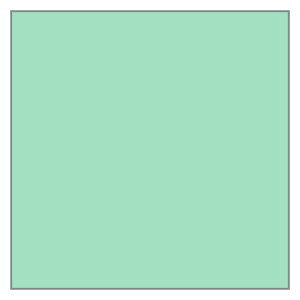

In [27]:
shapely.geometry.box(*src.bounds)

Note that the expression uses the positional arguments technique (see {ref}`positional-arguments`).

```{admonition} Exercise 10-b
:class: important
* How can we create a `GeoDataFrame` with one polygon feature, representing the raster bounds?
```

(rasterio-plotting)=
## Plotting (`rasterio`)

### Plotting a raster

To get a sense of the information in the raster, a basic plot can be produced using the `show` function. When the raster file connection contains three bands, these are treated as $Red$, $Green$, and $Blue$ (in that order), and displayed as an RGB image:

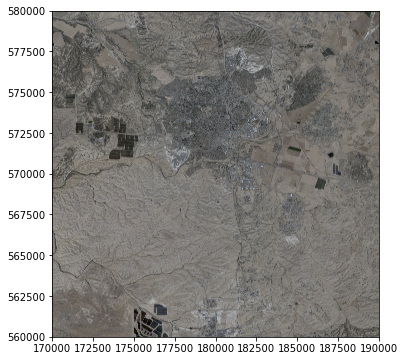

In [28]:
show(src);

We can also pass a tuple with a raster file connection and an index of a particular band, in which case we get an image of that band only. Note that `rasterio` band numbering start from `1`, so band `1` corresponds to the first ($Red$) band:

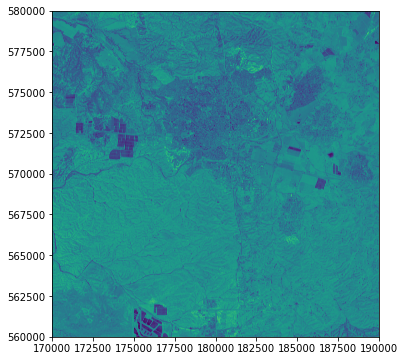

In [29]:
show((src, 1));

When displaying a single band, we can specify a color scale with the `cmap` argument, similarly to `.plot` in `geopandas` (see {ref}`geopandas-symbology`). It is standard practice to display a single band with the `"Greys_r"` ("greys reversed") color palette, where high values (i.e., high reflectance) appear bright, and low values appear dark:

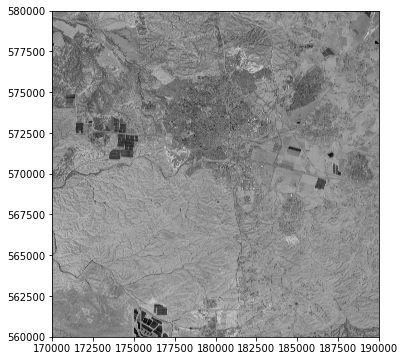

In [30]:
show((src, 1), cmap="Greys_r");

```{note}
See the *Plotting* section in the `rasterio` documentation for more details and examples: <https://rasterio.readthedocs.io/en/latest/topics/plotting.html>.
```

(plotting-raster-and-vector-layer)=
### Plotting a raster and a vector layer

To plot a raster and a vector layers together, we need to set a plot object, and pass the same `ax` argument [to both plots](https://stackoverflow.com/questions/57535504/how-to-plot-spatial-points-over-a-raster-layer-python). For example, let us import the railway lines layer and filter the active lines (see {ref}`reading-vector-layers` and {ref}`subsetting-by-attributes`):

In [31]:
rail = gpd.read_file('data/RAIL_STRATEGIC.shp')
rail = rail[rail['ISACTIVE'] == 'פעיל']

Here is how we can plot the railway lines and the aerial photo together:

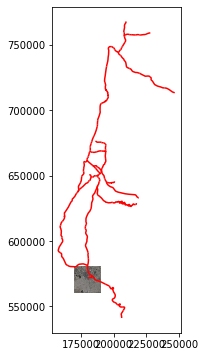

In [32]:
fig, ax = plt.subplots()
show(src, ax=ax)
rail.plot(ax=ax, edgecolor='red');

Keep in mind that, as usual, that both layers need to be in the same CRS for an operation involving both to make sense. In this case the `BSV_res200-M.tif` is in the ITM (EPSG `2039`) CRS, same as `RAIL_STRATEGIC.shp`, even though the CRS definition is missing from the `.tif` file.

(reading-raster-data)=
## Reading raster data

### Overview

As shown above, opening a raster file with `rasterio.open` creates a file connection object, containing raster metadata (see {ref}`raster-file-connection`). However, the raster data, that is, the array of raster *values*, was not read into memory.

To read the raster values we need to use the [`.read`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.read) method of the file connection object. The separation of creating a file connection and actually reading the raster values into separate steps may feel cumbersome. However, this type of design has advantages in terms of memory-use efficiency. For example, in case the raster is very large we can read only part of the information, or process it in consecutive "chunks", so that we do not consume too much RAM which will make the computer "freeze". 

### Reading all bands

To read all raster bands into an in-memory `numpy` array, we use the `.read` method without specifying any parameters. For example, the following expression reads the raster values from all bands, into an `ndarray` object named `r`:

In [33]:
r = src.read()
r

array([[[115, 132,  75, ..., 110, 103, 111],
        [133, 141, 135, ..., 105,  96,  94],
        [111, 147, 140, ...,  94,  97, 103],
        ...,
        [140,  68,  94, ..., 122, 128, 129],
        [148, 108, 124, ..., 131, 124, 134],
        [150, 119, 136, ..., 110, 137, 130]],

       [[111, 129,  75, ..., 101,  98, 106],
        [132, 140, 132, ...,  99,  92,  88],
        [111, 143, 136, ...,  87,  92,  96],
        ...,
        [133,  75,  89, ..., 120, 127, 127],
        [139, 105, 111, ..., 129, 126, 133],
        [140, 108, 128, ..., 104, 139, 127]],

       [[113, 122,  76, ...,  95,  90,  96],
        [125, 132, 128, ...,  90,  84,  83],
        [113, 137, 132, ...,  80,  84,  88],
        ...,
        [123,  74,  90, ..., 119, 121, 124],
        [128, 102, 104, ..., 124, 120, 127],
        [131, 106, 120, ..., 104, 134, 121]]], dtype=uint8)

```{note}
Thanks to the fact that `numpy` data types corresponds to file storage types, reading all raster values into memory consumes approximately the same amount of RAM as the file size on disk, that is, the minimal required amount of memory. For example, run the expression `import sys; round(sys.getsizeof(r)/1024/1024,2)` which returns the array object size, in Megabytes (MB), and compare the result with the original file size.
```

When reading all raster bands, we get a *three-dimensional* array. The order of the dimensions is `(bands,rows,columns)`:

In [34]:
r.shape

(3, 10000, 10000)

Once we have an array with all bands, such as `r`, we can always subset a particular band (or any other type of subset), using the `numpy` subsetting methods (see {ref}`subsetting-arrays`). For example, the following expression "pulls out" a two-dimensional array with the values of the 1<sup>st</sup> raster band:

In [35]:
r[0, :, :]

array([[115, 132,  75, ..., 110, 103, 111],
       [133, 141, 135, ..., 105,  96,  94],
       [111, 147, 140, ...,  94,  97, 103],
       ...,
       [140,  68,  94, ..., 122, 128, 129],
       [148, 108, 124, ..., 131, 124, 134],
       [150, 119, 136, ..., 110, 137, 130]], dtype=uint8)

We will also use the following shortcut, for clearer syntax of selecting an entire band, such as in raster algebra operations involving multiple bands (see {ref}`calculating-indices`):

In [36]:
r[0]

array([[115, 132,  75, ..., 110, 103, 111],
       [133, 141, 135, ..., 105,  96,  94],
       [111, 147, 140, ...,  94,  97, 103],
       ...,
       [140,  68,  94, ..., 122, 128, 129],
       [148, 108, 124, ..., 131, 124, 134],
       [150, 119, 136, ..., 110, 137, 130]], dtype=uint8)

### Reading specific bands

In case we need specific bands, to conserve memory, it is better to read just the band we need in the first place. This can be done by specifying the band index inside `.read`. Keep in mind that `rasterio` band indices starts from `1`. For example, here we read each of the bands `1`, `2`, and `3`, into separate arrays named `red`, `green`, and `blue`, respectively:

In [37]:
red = src.read(1)
green = src.read(2)
blue = src.read(3)

Each of `red`, `green`, and `blue` is a *two*-dimensional array. For example:

In [38]:
red.shape

(10000, 10000)

Again, note that `.read()` imports the raster data into a *three*-dimensional array, while `.read(1)`, `.read(2)`, etc. import the raster data into a *two*-dimensional array. Therefore, `.read()` and `.read(1)` do not produce the same result even if the raster data source is *one-dimensional*. Here is a short demonstration, using a single-band raster file which we will work with later on (see {ref}`stacking-raster-bands`):

In [39]:
rasterio.open('data/T36RXV_20201226T082249_B02.jp2').read().shape

(1, 2968, 3554)

In [40]:
rasterio.open('data/T36RXV_20201226T082249_B02.jp2').read(1).shape

(2968, 3554)

It is also possible to read several bands at once, by specifying a `list` of bands. For example, here we read the third and second bands (in that order):

In [41]:
src.read([3, 2])

array([[[113, 122,  76, ...,  95,  90,  96],
        [125, 132, 128, ...,  90,  84,  83],
        [113, 137, 132, ...,  80,  84,  88],
        ...,
        [123,  74,  90, ..., 119, 121, 124],
        [128, 102, 104, ..., 124, 120, 127],
        [131, 106, 120, ..., 104, 134, 121]],

       [[111, 129,  75, ..., 101,  98, 106],
        [132, 140, 132, ...,  99,  92,  88],
        [111, 143, 136, ...,  87,  92,  96],
        ...,
        [133,  75,  89, ..., 120, 127, 127],
        [139, 105, 111, ..., 129, 126, 133],
        [140, 108, 128, ..., 104, 139, 127]]], dtype=uint8)

(creating-raster-from-array)=
## Creating raster from array

In some cases, we may need to go the other way around: transforming an array into a raster. For example, we may be given an array (e.g., in a CSV file) and the extent and CRS information, and asked to store the information in a spatial raster file format such as GeoTIFF. As we have seen above, a raster is just an array associated with spatial metadata, namely:

* Origin and resolution (`.transform`)
* CRS definition (`.crs`)

Therefore, going from an array to a raster technically means we need to construct the `.transform` and `.crs` objects.

To demonstrate, let us import the `carmel.csv` matrix, which contains a Digital Elevation Model (DEM) of the area around Haifa (see {ref}`numpy-reading-from-file`):

In [42]:
m = np.genfromtxt('data/carmel.csv', delimiter=',')
m

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Using the `show` function, here is a visualization of the resulting `m` array:

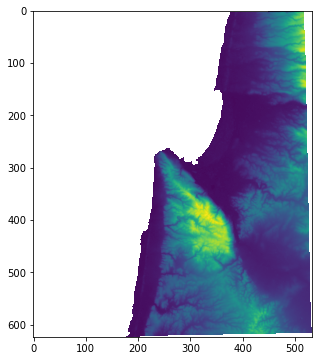

In [43]:
show(m);

The `m` array is defined as `float64`:

In [44]:
m.dtype

dtype('float64')

However, it actually contains only integers. To be more efficient, we will therefore convert (see {ref}`numpy-changing-data-type`) it to an `int16` array. Since `int` arrays cannot contain "No Data" values (see {ref}`no-data-representation`), we are going to encode "No Data" as `-9999`, which is a value never encountered in DEMs and a common convention:

In [45]:
m[np.isnan(m)] = -9999
m = m.astype(np.int16)
m

array([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

Why is `-9999` a good choice for representing "No Data" values in a DEM?

* It is *invalid* with repect to the measured variable, since there is no place on earth where elevation is `-9999` meters below sea level. If someone encounters the value `-9999` in a DEM, they can be fairly certain that it represents "No Data" even without looking into the metadata.
* It is *extreme*. Therefore, if it accidently does get into a calculation (such as zonal mean of elevation), there is a good chance the results are going to be skewed which will catch the analysts' attention so that they can spot the mistake.

Now, what is missing is the raster georeferencing information: the `.transform` matrix and the CRS definition. This information needs to be known in advance. If we do not have it, we can try to manually georeference the raster using control points (such as landmarks, trees, large stones, etc.), however this may be difficult and error-prone, unless the raster is a high-resolution aerial photograph. In this example, let us assume that the origin and resolution of the raster are known in advance. In such case, we can use the [`rasterio.transform.from_origin`](https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.from_origin) function to create a `.transform` object:

In [46]:
new_transform = rasterio.transform.from_origin(west=662317, north=3658412, xsize=90, ysize=90)
new_transform

Affine(90.0, 0.0, 662317.0,
       0.0, -90.0, 3658412.0)

Also, let us assume that we know the CRS of the raster, and that it is UTM Zone 36N (`32636`).

Now we have all necessary information to export the Haifa DEM into a spatial raster format such as GeoTIFF, which is what we do next.

(writing-rasters)=
## Writing rasters

(writing-single-band-raster)=
### Writing single-band (`int`)

To write an array into a raster file, we need to pass a (non-existing) raster file path to `rasterio.open`, in writing (`"w"`) mode. As opposed to read mode, the `open` function needs quite a lot of information (in addition to the file path and mode):

* `driver`—The file format (The recommendation is `"GTiff"`)
* `height`—Number of rows
* `width`—Number of columns
* `count`—Number of bands
* `nodata`—The value which represents "No Data", if any
* `dtype`—The raster data type, one of `numpy` types (e.g., `np.int16`)
* `crs`—The CRS, using an EPSG code (e.g., `32636`)
* `transform`—The transform matrix
* `compress`—a compression method to apply, such as `'lzw'`. This is optional and most useful for large rasters. Note that, at the time of writing, this [doesn't work well](https://gis.stackexchange.com/questions/404738/why-does-rasterio-compression-reduces-image-size-with-single-band-but-not-with-m) for writing multiband rasters.

We already have all the necessary information. Here is the expression to open a GeoTIFF file named `carmel.tif` in writing mode, with the right arguments to store the Haifa DEM values in array `m`:

In [47]:
new_dataset = rasterio.open(
    'output/carmel.tif', 'w', 
    driver = 'GTiff',
    height = m.shape[0],
    width = m.shape[1],
    count = 1,
    nodata = -9999,
    dtype = m.dtype,
    crs = 32636,
    transform = new_transform,
    compress='lzw'
)

```{admonition} Exercise 10-c
:class: important
* Go over the arguments in the above `rasterio.open` function call, and make sure you understand where they come from and what is their meaning.
```

Note that the data are not written into the file yet! To do that, once the file connection is ready, we use the `.write` method to actually write the array into the file connection. When writing, we need to specify the array with the data to write (such as `m`), and the band index where the data will be written. Note that the band index starts from `1`: 

In [48]:
new_dataset.write(m, 1)

In the end, we must "close" the file connection using the `.close` method. This is particularly important in writing mode, as closing assures that writing is completed:

In [49]:
new_dataset.close()

(writing-single-band-float)=
### Writing single-band (`float`)

In case we choose to write a `float` raster, the recommendation is to specify missing values using `np.nan`. To demonstrate, let us go back to the original `float64` array:

In [50]:
m = np.genfromtxt('data/carmel.csv', delimiter=',')
m

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

The following expressions writing the array into another file named `carmel2.tif`. The arguments in `rasterio.open` are almost identical, except for `nodata` which is left unspecified:

In [51]:
new_dataset = rasterio.open(
    'output/carmel2.tif', 'w', 
    driver = 'GTiff',
    height = m.shape[0],
    width = m.shape[1],
    count = 1,
    dtype = m.dtype,
    crs = 32636,
    transform = new_transform
)
new_dataset.write(m, 1)
new_dataset.close()

The resulting raster is going to have a "native" encoding of "No Data", with no need to specify a particular numeric value such as `-9999`. When reading the raster back into an array, the "No Data" will be interpreted as `np.nan`:

In [52]:
rasterio.open('output/carmel2.tif').read()

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

(stacking-raster-bands)=
### Stacking raster bands

Remote sensing products, such as satellite images, are often distributed as a collection of single-band files, one file for each spectral band of the sensor. For example, Landsat and Sentinel satellite images are distributed in this way. In this section, we are going to learn how to "stack" separate single-band raster files into a multi-band raster which is easier to work with, and to view in GIS software.

First, we will create a `list` with the file paths of the separate raster files which we are going to stack. The sample image is a Sentinel-2 satellite image of central/southern Israel from 2020-12-26. Sentinel-2 satellite images are distributed in a raster format called JPEG2000 (`.jp2`). The image original contains 14 bands. To keep things more simple, the sample data contains just four out of 14 files, the ones which are usually important: the red, green, blue, and Near Infrared bands. Here are their file paths:


In [53]:
path = 'data/T36RXV_20201226T082249_'
files = [
    path + 'B02.jp2',  # Blue
    path + 'B03.jp2',  # Green
    path + 'B04.jp2',  # Red
    path + 'B08.jp2'   # NIR
]
files

['data/T36RXV_20201226T082249_B02.jp2',
 'data/T36RXV_20201226T082249_B03.jp2',
 'data/T36RXV_20201226T082249_B04.jp2',
 'data/T36RXV_20201226T082249_B08.jp2']

The aboves code section requires that we manually type the file name components, and that we know in advance the number of files. A more automated approach would be to *search* the files according to a patrticular pattern inside a given directory. For example, relying on the fact that the Sentinel-2 images files we are interested in are located in the `data` directory and characterized by the `.jp2` extension, we can get the same `list` with their paths using shorter code, and the taking advantage of the `glob` standard package, as follows:

In [54]:
files = glob.glob('data/*.jp2')
files

['data/T36RXV_20201226T082249_B03.jp2',
 'data/T36RXV_20201226T082249_B02.jp2',
 'data/T36RXV_20201226T082249_B04.jp2',
 'data/T36RXV_20201226T082249_B08.jp2']

However, in this case we also need to manually sort (see {ref}`list-methods`) the files, so that they match the intended order of bands in the multi-band raster we will be writing:

In [55]:
files.sort()
files

['data/T36RXV_20201226T082249_B02.jp2',
 'data/T36RXV_20201226T082249_B03.jp2',
 'data/T36RXV_20201226T082249_B04.jp2',
 'data/T36RXV_20201226T082249_B08.jp2']

Since the files comprise "bands" of the same image, the spatial metadata of all images is identical. Therefore, to write a multi-band raster we are going to use the spatial metadata from one of the images. It does not matter which one, so we are going to use the first image. First, we create the file connection:

In [56]:
src = rasterio.open(files[0])
src

<open DatasetReader name='data/T36RXV_20201226T082249_B02.jp2' mode='r'>

Then, we extract the spatial metadata (see {ref}`raster-properties`), and keep it in a separate object which we will use later on:

In [57]:
meta = src.meta
meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 3554,
 'height': 2968,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.000856049521643, 0.0, 652642.4115,
        0.0, -10.000219878706249, 3473256.1222)}

Before we can use this `meta` object when writing the multi-band raster, we need to modify two of its properties:

* `count`—The number of bands, needs to be `4` instead of `1`
* `driver`—Needs to be GeoTIFF (`"GTiff"`) instead of JPEG2000, since this is the file format is best supported for writing with `rasterio` (see {ref}`writing-single-band-raster`) 

`rasterio` has a specialized method named `.update`, to update metadata objects, as follows:

In [58]:
meta.update(count=len(files))
meta.update(driver='GTiff')

Let us check the `meta` object to make sure the properties were actually updated:

In [59]:
meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 3554,
 'height': 2968,
 'count': 4,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.000856049521643, 0.0, 652642.4115,
        0.0, -10.000219878706249, 3473256.1222)}

Now that we have the list of files (`files`), and the updated spatial metadata from one of the files (`meta`), we proceed to actually writing the multi-band raster. Here is the code to do that:

In [60]:
dst = rasterio.open('output/sentinel2.tif', 'w', **meta)
for index, filename in enumerate(files, start=1):
    src = rasterio.open(filename)
    dst.write(src.read(1), index)
    src.close()
dst.close()

This code section is relatively complex, so we will now go over the main points to pay attention to. First, note that we have two `rasterio.open` expressions:

* On the "top" level, we open a file named `"output/sentinel2.tif"` (which may not exist yet) in *writing* mode as `dst`. This is where we write the multi-band raster. Note that we pass the `meta` object as keyword arguments (see {ref}`keyword-arguments`) with `**meta`.
* Inside the `for` loop which goes over the `files`, we open each file in *reading* mode. Using the `enumerate` technique (see {ref}`using-enumerate`), in each iteration we have access to the current band `index` starting from `1` (i.e., `1`, `2`, `3`, and `4`) and the current file name (`filename`). Inside the loop, we then read the first (and only) band of each file (`src.read`), and immediately write it to the respective band `index` in the destination file (`dst.write(..., index)`).

The above code created a new file named `sentinel2.tif`, which we can now read back into the Python session to work with it:

In [61]:
src = rasterio.open('output/sentinel2.tif')
src

<open DatasetReader name='output/sentinel2.tif' mode='r'>

Examining the metadata tells us that this is indeed a four-band raster:

In [62]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 3554,
 'height': 2968,
 'count': 4,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.000856049521643, 0.0, 652642.4115,
        0.0, -10.000219878706249, 3473256.1222)}

Here is how we can read all layers at once into a three-dimensional array anmed `r`:

In [63]:
r = src.read()
r

array([[[1600, 1560, 1598, ..., 1272, 1315, 1316],
        [1614, 1570, 1608, ..., 1196, 1262, 1316],
        [1630, 1584, 1619, ..., 1131, 1191, 1295],
        ...,
        [1597, 1576, 1599, ..., 2149, 2201, 2169],
        [1602, 1597, 1569, ..., 2220, 2237, 2228],
        [1577, 1577, 1563, ..., 2191, 2296, 2195]],

       [[1735, 1681, 1719, ..., 1361, 1396, 1358],
        [1747, 1711, 1723, ..., 1245, 1356, 1398],
        [1766, 1754, 1739, ..., 1133, 1240, 1344],
        ...,
        [1738, 1722, 1747, ..., 2501, 2602, 2647],
        [1736, 1736, 1705, ..., 2655, 2684, 2671],
        [1688, 1690, 1680, ..., 2652, 2719, 2693]],

       [[2107, 2101, 2107, ..., 1514, 1610, 1568],
        [2120, 2108, 2104, ..., 1294, 1510, 1549],
        [2140, 2124, 2109, ...,  983, 1248, 1463],
        ...,
        [2224, 2229, 2250, ..., 3265, 3337, 3440],
        [2248, 2195, 2229, ..., 3486, 3468, 3556],
        [2207, 2163, 2229, ..., 3452, 3574, 3529]],

       [[2793, 2710, 2797, ..., 2810,

When plotting an RGB image of the raster we need to make sure the bands are arranged in the Red-Green-Blue order, as follows. Nevertheless, something goes wrong and we see a balnk image. The problem is that (as stated in the printed message) integer values are interpreted as occupying the `0`-`255` range, while in this case the values are reflectance (`0`-`1`) multiplied by `10000`, thus occupything the `0`-`10000` range. We are going to fix this shortly (see {ref}`rescaling`).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


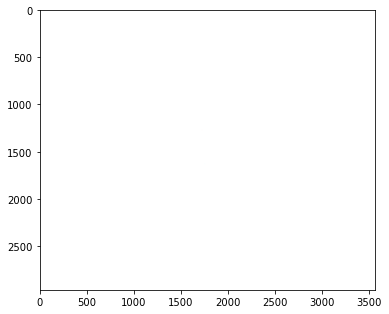

In [64]:
show(r[[2, 1, 0], :, :]);

(rasterio-nodata-masks)=
## "No Data" in rasters

### Overview

Rasters may contain "No Data", i.e., pixels that have missing values. For example, remote sensing data, such as satellite images, may contain "No Data" pixel values to mark unreliable or unusable values, due to atmospheric interference such as clouds. In other cases, the "No Data" values may be used to mask the pixels beyond the area of interest, such as elevation over over water bodies (see {ref}`writing-rasters`).

(no-data-representation-int)=
### "No Data" representation (`int`)

An `int` raster file that has "No Data" must store a flag that specified which specific value is used to represent "No Data", accessible through the `.nodata` property (see {ref}`raster-properties`). 

As discussed earlier, due to memory-related limitations (see {ref}`no-data-representation`), missing values cannot be represented by `np.nan` in `int` arrays. Accordingly, when reading an `int` raster into an array, `.nodata` values are interpreted as ordinary numeric values (such as `-9999`). It is up to the user to decide what to do in such case:

* Keep the raster as is, while being mindful of the numeric value representing "No Data" and excluding them from calculations
* Use a "No Data" mask along with the raster values (see {ref}`no-data-masks`)
* Transforming the raster to `float`, then replace "No Data" values with `np.nan`

### "No Data" representation (`float`)

A `float` raster that has "No Data" may, or may not, specify a particular numeric value as `.nodata`, since it can also use the native "No Data" value which does not require specifying one. Therefore, confusingly, `float` rasters *can* represent "No Data" values using either of two approaches:

* A "native", data type-specific, encoding, in which case the "No Data" values are automatically interpreted as `np.nan`
* A specific numeric value, such as `-9999`, in which case the value is being interpreted as is (i.e., as `-9999`) similarly to `int` (see {ref}`no-data-representation-int`)

Here is an example of the first case (see {ref}`writing-single-band-float`), native "No Data" encoding which is automatically translated to `np.nan`:

In [65]:
rasterio.open('output/carmel2.tif').meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 533,
 'height': 624,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(90.0, 0.0, 662317.0,
        0.0, -90.0, 3658412.0)}

In [66]:
rasterio.open('output/carmel2.tif').read()

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

Here is an example of the second case ({ref}`topographic-aspect`), "No Data" encoded using a numeric value which is *not* translated to `np.nan`:

In [67]:
rasterio.open('output/carmel_aspect.tif').meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 533,
 'height': 624,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(90.0, 0.0, 662317.0,
        0.0, -90.0, 3658412.0)}

In [68]:
rasterio.open('output/carmel_aspect.tif').read()

array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      dtype=float32)

The latter behavior may seem inconvenient. However, it makes sure that treatment of the `.nodata` flag is the same in both `int` and `float` rasters.

(no-data-masks)=
### "No Data" masks

Let us go back to the `carmel.tif` raster with the DEM of the Carmel area created earlier (see {ref}`writing-rasters`). Recall that the `numpy` array with raster values which we wrote to file contained missing values (in the form of `np.nan`), representing undetermined elevation for the Mediterranean sea. Before writing it to the `carmel.tif` raster file, we chose to convert the values into `int`, which, due to computer memory limitations, cannot represent `np.nan`. Therefore `np.nan` values were encoded as `-9999`, and the `nodata=-9999` flag was specified in the `carmel.tif` file metadata (see {ref}`writing-rasters`).

Indeed, if we read back the file `carmel.tif`, we can see that the `.nodata` property is set to `-9999` in the raster metadata:

In [69]:
src = rasterio.open('output/carmel.tif')
src.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 533,
 'height': 624,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(90.0, 0.0, 662317.0,
        0.0, -90.0, 3658412.0)}

As discussed above, when reading the data using `.read` (whether `int` or `float`), the values `.nodata` values are read as is:

In [70]:
src.read(1)

array([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

What can we do in case when a raster encodes "No Data" as a specific numeric value, and yet we would like to ignore that value in calculations? One of the the solutions is to use a "No Data" mask, i.e., an additional array which indicates which values in the original array are valid, or "No Data".

There are two ways to create a "No Data" mask with `rasterio`. First, using the additional `masked=True` argument of `.read`, we can read the raster data into a special type of a `numpy` array known as a [masked array](https://numpy.org/doc/stable/reference/maskedarray.generic.html#what-is-a-masked-array): 

In [71]:
r = src.read(1, masked=True)
r

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999,
  dtype=int16)

Detailed description of the masked array data structure is beyond the scope of this book. In short, a masked array is composed of two components:

* `.data`—The data (e.g., `dem1.data`)
* `.mask`—A boolean "NoData" mask (e.g., `dem1.mask`)

For example:

In [72]:
r.data

array([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

In [73]:
r.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Importantly, `numpy` operators and functions are aware of the "No Data" mask, and automatically exclude the masked values from calculations. For example:

In [74]:
r.mean()

124.0609638124817

Second, we can read the data as an ordinary array using plain `.read`, and then also read the "No Data" mask into a separate array using the [`.read_masks`](https://rasterio.readthedocs.io/en/latest/topics/masks.html#reading-dataset-masks) method:

In [75]:
r = src.read(1)
mask = src.read_masks(1)

In the resulting "NoData" array, missing values are indicated by `0`, while valid values are indicated by `255`:

In [76]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In this case, it is up to the user to exclude the masked values where necessary.

(working-with-raster-values)=
## Working with raster values

### Overview

Now that we know how to gain access to raster data, in the form of `numpy` arrays, we can perform many types of common raster operations which require just the raster values. For exampe, we can:

* {ref}`summarizing-values`—Summarize raster values, globally or separately per band
* {ref}`rescaling`—Linearly translate the raster values to a different data range
* {ref}`calculating-indices`—Calculating a single-band raster using a formula, applied on several raster bands, such as calculating an NDVI image from red and near-infrared bands 
* {ref}`reclassifying`—Convert a continuous raster to a categorical one

We will now see an example of each.

(summarizing-values)=
### Summarizing values

For the next examples, let us go back to the Sentinel-2 image:

In [77]:
src = rasterio.open("output/sentinel2.tif")
r = src.read()

To summarize raster values, either globally, or for specific dimensions, we can use `numpy` functions, possibly specifying the `axis` argument (see {ref}`numpy-global-summaries`). For example, the "global" minimum and maximum values of the raster—across the all bands and pixels—can be obtained with:

In [78]:
np.min(r)

0

In [79]:
np.max(r)

27999

To get the minimum and maximum of all pixels separately *per band*, recall that `rasterio` places the bands into the `0` dimension:

In [80]:
r.shape

(4, 2968, 3554)

Therefore, we need to specify `axis=(1,2)`, i.e., the axes that we want to summarize and "discard" are `1` and `2` (see {ref}`numpy-summaries-per-dimension-3d`). For example, here are the minimum values in each of the four bands of the Sentinel-2 image:

In [81]:
np.min(r, axis=(1, 2))

array([ 94,   0,   0, 284], dtype=uint16)

and here are the maximum values:

In [82]:
np.max(r, axis=(1, 2))

array([27994, 26490, 27992, 27999], dtype=uint16)

```{admonition} Exercise 10-d
:class: important
* Write an expression that returns the average value per pixel. 
* The result should be a two-dimensional array of size `2968`*`3554` (check your answer using the `.shape` property).
```

(rescaling)=
### Rescaling

Rescaling and calculating indices (see {ref}`calculating-indices`) are examples of operations that are applied on each pixel, separately, to compose a new raster with the results. This type of operations are collectively known as *raster algebra*. 

For example, the Sentinel-2 images are stored as `uint16`, for conserving storage space, but they need to be rescaled by dividing each pixel value by `10000` to get the true reflectance values. This is a common "compression" technique when storing satellite images. 

To get the reflectance values, we need to rescale all values dividing the entire array by `10000`:

In [83]:
r = r / 10000
r

array([[[0.16  , 0.156 , 0.1598, ..., 0.1272, 0.1315, 0.1316],
        [0.1614, 0.157 , 0.1608, ..., 0.1196, 0.1262, 0.1316],
        [0.163 , 0.1584, 0.1619, ..., 0.1131, 0.1191, 0.1295],
        ...,
        [0.1597, 0.1576, 0.1599, ..., 0.2149, 0.2201, 0.2169],
        [0.1602, 0.1597, 0.1569, ..., 0.222 , 0.2237, 0.2228],
        [0.1577, 0.1577, 0.1563, ..., 0.2191, 0.2296, 0.2195]],

       [[0.1735, 0.1681, 0.1719, ..., 0.1361, 0.1396, 0.1358],
        [0.1747, 0.1711, 0.1723, ..., 0.1245, 0.1356, 0.1398],
        [0.1766, 0.1754, 0.1739, ..., 0.1133, 0.124 , 0.1344],
        ...,
        [0.1738, 0.1722, 0.1747, ..., 0.2501, 0.2602, 0.2647],
        [0.1736, 0.1736, 0.1705, ..., 0.2655, 0.2684, 0.2671],
        [0.1688, 0.169 , 0.168 , ..., 0.2652, 0.2719, 0.2693]],

       [[0.2107, 0.2101, 0.2107, ..., 0.1514, 0.161 , 0.1568],
        [0.212 , 0.2108, 0.2104, ..., 0.1294, 0.151 , 0.1549],
        [0.214 , 0.2124, 0.2109, ..., 0.0983, 0.1248, 0.1463],
        ...,
        [0.2

Now that we have a `float64` raster with values between `0` and `1`, we can observe an RGB image of the raster as follows:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


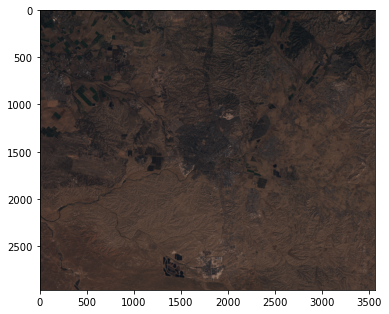

In [84]:
show(r[[2, 1, 0], :, :]);

(reclassifying)=
### Reclassifying

When examining the range of values, we find out that we have values above `1`, even though valid values of reflectance are between `0` and `1`:

In [85]:
[r.min(), r.max()]

[0.0, 2.7999]

```{admonition} Exercise 10-e
:class: important
* How many *values* `>1` do we have in `a`? (answer: `228`)
* How many *pixels* with at least one value `>1` do we have? (answer: `120`) 
```

Higher values [can arise](https://forum.step.esa.int/t/sr-sentinel-2-values-greater-than-1/30980/5), for example, as an interaction between particular atmospheric correction algorithms and particular surface characteristics. These values are considered outliers and usually are either replace with `1` or transformed to "No Data".

This is an example of *reclassifying*, grouping all or same ranges of data values in the raster into uniform categories where all pixels share the same value. In this case, we want to replace all pixels with `>1` into `1`. Technically, this is a `numpy` "assignment to subset" operation, which we are already familiar with (see {ref}`masking`):

In [86]:
r[r > 1] = 1

Let us check the data range of the modified raster. Indeed, the data range is now `0`-`1`: 

In [87]:
[r.min(), r.max()]

[0.0, 1.0]

(calculating-indices)=
### Calculating indices

Calculating *indices* is a raster algebra operation where we use a particular formula to calculate a single-band image, from a multi-band image. The formula is applied on the values of each pixel, separately, and the individual calculations then comprise the resulting single-band image. There is a wide variety of useful indices developed in image analysis and remote sensing practice. We will see two examples:

* Calculating a greyscale image from red, green, and blue bands
* Calculating an NDVI image from red and near-infrared bands 

Let us start with the [grayscale](https://en.wikipedia.org/wiki/Grayscale) image. Given $Red$, $Green$, and $Blue$, bands, a simple formula for a greyscale image is calculating the [weighted average reflectance](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html) from all three bands, as follows: 

$$Grey=0.2125 \times Red + 0.7154 \times Green + 0.0721 \times Blue$$

In the resulting greyscale image, pixels that have high averaged reflectance will have high greyscale values and will appear bright. Pixels that have low average reflectance will appear dark. 

Here is how we can calculate a greyscale image from our Sentinel-2 data, using `numpy` vectorized arithmetic operations (see {ref}`numpy-vectorized-ops`):

In [88]:
greyscale = 0.2125*r[2] + 0.7154*r[1] + 0.0721*r[0]
greyscale

array([[0.18043165, 0.17615259, 0.17927259, ..., 0.13870956, 0.14356349,
        0.13995968],
       [0.18166732, 0.17851964, 0.1795671 , ..., 0.12518796, 0.13819476,
        0.14241753],
       [0.18356694, 0.1820368 , 0.1808973 , ..., 0.11009808, 0.12381671,
        0.13657546],
       ...,
       [0.18311089, 0.18192109, 0.18432167, ..., 0.26379708, 0.27292754,
        0.27810487],
       [0.18351386, 0.18235156, 0.18065444, ..., 0.2800224 , 0.28183713,
        0.28271222],
       [0.17902844, 0.17823652, 0.17882268, ..., 0.27887619, 0.28701892,
        0.28347442]])

The resulting greyscale image can be displayed as follows:

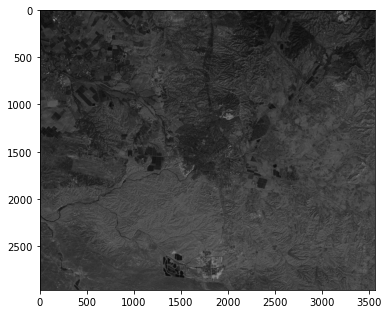

In [89]:
show(greyscale, cmap='Greys_r');

Let us move on to the second example, calculating an NDVI image. [NDVI (Normalized Difference Vegetation Index)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) is a common remote sensing index, based on $Red$ and Near-Infrared ($NIR$) reflectance, emphasizing green vegetation. The NDVI is defined as follows:

$$NDVI=\frac{NIR-Red} {NIR+Red}$$

Here is how we apply this formula to our Sentinel-2 image:

In [90]:
ndvi = (r[3] - r[2]) / (r[3] + r[2])
ndvi

array([[0.14      , 0.12658491, 0.14070147, ..., 0.29972248, 0.26146789,
        0.26984866],
       [0.15047085, 0.13375796, 0.13664341, ..., 0.38731061, 0.31643278,
        0.29107551],
       [0.14382877, 0.13605857, 0.14198535, ..., 0.5057818 , 0.40811003,
        0.32751092],
       ...,
       [0.09335508, 0.09921196, 0.09692956, ..., 0.05553949, 0.06145409,
        0.04998619],
       [0.0926337 , 0.09782162, 0.08964672, ..., 0.04974785, 0.05927031,
        0.04856187],
       [0.08914569, 0.09630249, 0.08908868, ..., 0.05008255, 0.05934991,
        0.04891524]])

The possible range of NDVI values is between `-1` and `1`, however typical targes such as soil, built areas, and vegetation, produce positive NDVI values, between `0` and `1`, whereas dense vegetation produces high NDVI values (up to ~`0.8`). Water bodies, clouds, and snow, produce zero or negative NDVI values. The distribution (see {ref}`numpy-hist`) of NDVI values we got, where most values are between `0.05` and `0.30`, is characteristic to dry areas with sparse vegetation cover:

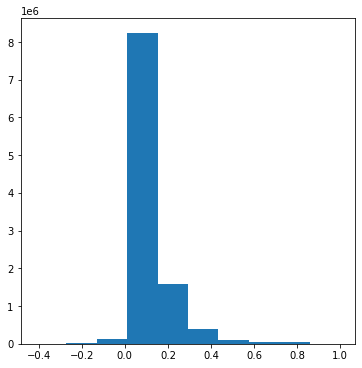

In [91]:
plt.hist(ndvi.flatten());

The following expression displays the NDVI image which we created, using the `"Greens"` color palette. We can see that densely vegetated areas, such as agricultiral fields (top-left corner of the image), are emphasized due to their high NDVI values:

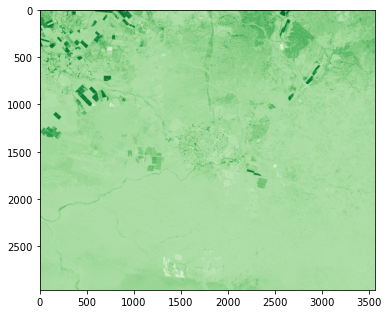

In [92]:
show(ndvi, cmap="Greens");

(dem-calculations)=
## DEM calculations

### Overview

There is a large number of specialized GIS functions and operators applicable to DEMs. These include, for example:

* Topographic indices, such as slope and aspect
* Flow accumulation, contributing area, and basin/channel delineation
* Visibility, line of sight, and visible area

This type of operations is beyond the scope of `rasterio`, but there are other, more spatialized third-party Python packages for DEM analysis. In this section, we are going to demonstrate calculation of topographic indices, namely topographic aspect, using the `richdem` package. 

```{note}
Check out the documentation of `richdem` to get an idea of the other DEM-related operations available in this package: <https://richdem.readthedocs.io/en/latest/intro.html>.
```

`richdem` comes with its own functions to import and export data, named `rd.LoadGDAL` and `rd.SaveGDAL`, respectively. Accordingly, `richdem` defines its own class for storing rasters, called `rdarray`. We are not going to get into details about this data structure, because we already know how to the analogous operations (such as pre-processing, or examining the properties of rasters) using `rasterio`. Our strategy for working with `richdem` will be as follows:

* Import a DEM from a `.tif` file (which may have been prepared using `rasterio`) using `rd.LoadGDAL`
* Apply `richdem` functions as necessary
* Export the result using `rd.SaveGDAL` (perhaps for further processing with `rasterio`)

(topographic-aspect)=
### Topographic aspect

Our example to demontrate the workflow of `richdem` is calculating a *topographic aspect* raster. In the derived topographic aspect raster, the value of each pixel reflects the direction where the surface of that pixel (and its $3\times3$ surrounding neighborhood) is facing, usually in decimal degrees (`0`-`360`). The ArcPro documentation has a good article named [How Aspect works](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-aspect-works.htm) with more details about the topographic aspect calculation.

First, we load the `carmel.tif` raster (see {ref}`writing-single-band-raster`) using function [`rd.LoadGDAL`](https://richdem.readthedocs.io/en/latest/loading_data.html#gdal) from the `richdem` package:

In [93]:
dem = rd.LoadGDAL('output/carmel.tif')

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


Here is what the resulting `rdarray` object looks like when printed. As you can see, it is very similar to a `numpy` array:

In [94]:
dem

rdarray([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         ...,
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

Importantly, the `rdarray` object keeps track of "No Data" value, which in our case is `-9999`:

In [95]:
dem.no_data

-9999.0

Now, we need to apply the `richdem` function for calculating topographic aspect given a DEM. This is done using [`rd.TerrainAttribute`](https://richdem.readthedocs.io/en/latest/terrain_attributes.html) with the argument `attrib="aspect"`:

In [108]:
aspect = rd.TerrainAttribute(dem, attrib='aspect')


A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918



[                                                  ] (1% - 0.0s - 1 threads)
[=                                                 ] (2% - 0.0s - 1 threads)
[=                                                 ] (3% - 0.0s - 1 threads)
[==                                                ] (4% - 0.0s - 1 threads)
[==                                                ] (5% - 0.0s - 1 threads)
[===                                               ] (6% - 0.0s - 1 threads)
[===                                               ] (7% - 0.0s - 1 threads)
[====                                              ] (8% - 0.0s - 1 threads)
[====                                              ] (9% - 0.0s - 1 threads)
[=====                                             ] (10% - 0.0s - 1 threads)
[=====                                             ] (11% - 0.0s - 1 th

Here is the result:

In [107]:
aspect

rdarray([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         ...,
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
        dtype=float32)

For examining the output (or further processing it), we will use the more familiar `rasterio` methods. For that, we need to export the resulting `aspect` object, using [`rd.SaveGDAL`](https://richdem.readthedocs.io/en/latest/python_api.html#richdem.SaveGDAL):

In [97]:
rd.SaveGDAL('output/carmel_aspect.tif', aspect)

Then, we can "re-import" it with `rasterio.open`:

In [98]:
aspect = rasterio.open('output/carmel_aspect.tif')

We can now, for example, plot the aspect raster to see what it looks like:

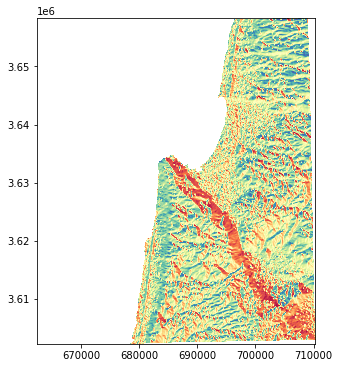

In [99]:
show(aspect, cmap='Spectral');

Here is another version of the plot, using a [workaround](https://stackoverflow.com/questions/61327088/rio-plot-show-with-colorbar) to add a legend. That way, we can see that the aspect values are between $0$ and $360$ (degrees) as expected:

<AxesSubplot:>

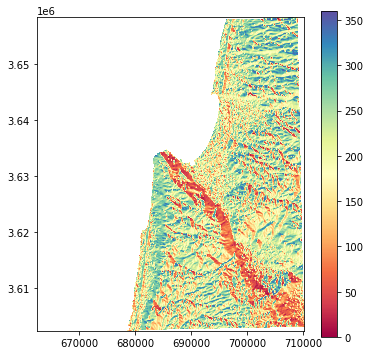

In [100]:
fig, ax = plt.subplots()
image_hidden = ax.imshow(aspect.read(1, masked=True), cmap='Spectral')
fig.colorbar(image_hidden, ax=ax)
show(aspect, ax=ax, cmap='Spectral')

(focal-filtering)=
## Focal filtering

Our final example with rasters with rasters demonstrates a well-known third-party package called [`scipy`](https://scipy.org/). `scipy` is a broad-scope and established packages for *scientific computing*. One of the sub-domains which the package deals with is *image processing*. Typical image processing operations include filtering (which we demonstrate below), segmentation, and edge detection. Though image processing is not specific to spatial rasters, most operations are applicable and relevant when dealing with spatial data. 

To work with `scipy`, as always, we first need to import it. The `scipy` is split to sub-packages addressing different domains. Each sub-module we want to work with needs to be imported [separately](https://stackoverflow.com/questions/8200348/ndimage-missing-from-scipy), as if it is a standalone package. The [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/tutorial/ndimage.html) sub-package (which we loaded earlier, see {ref}`rasterio-loading-packages`), for example, includes the image processing-related functions, such as functions for different types of filters. 

The most straightforward [filtering](https://pro.arcgis.com/en/pro-app/2.8/tool-reference/spatial-analyst/how-filter-works.htm) function is [`ndimage.uniform_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.uniform_filter.html), where each pixel in the "filtered" image is the average of pixel values inside a moving window of a specified size. For example, window size of $3$ implies that each pixel in the filtered image is the average of $3\times3=9$ neighborhood centered on the "focal" pixel being calculated.

Here is how we can apply a uniform focal filter with a window size of 3 on the `ndvi` image we calculated earlier. Note that `ndvi` is the `ndarray` with the NDVI values:

In [101]:
ndvi3 = scipy.ndimage.uniform_filter(ndvi, 3)

The result `ndvi3` is also an `ndarray`, of the same shape as `ndvi`. Only the values have changed. To understand how the calculation was carried out, we can compare the average of any particular $3\times3$ neighborhood in the original raster:

In [102]:
ndvi[0:3, 0:3].mean()

0.13889236590152285

with the "focal" pixel value of that neighborhood in the filtered raster:

In [103]:
ndvi3[1, 1]

0.13889236590152285

The values are identical, as expected.

Displaying the filtered raster should appear more blurred than the original image. This is difficult to see in our last example, because the raster is relatively large and the focal window is relatively small:

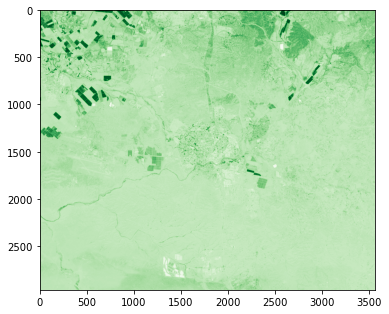

In [104]:
show(ndvi3, cmap='Greens');

```{admonition} Exercise 10-f
:class: important
* Try repeating the above with a larger filter size of `51` (instead of `3`). 
* Use `show` to see the result. The result should appear more blurred ({numref}`exercise-10-f`).
```

```{glue:figure} exercise-10-f
---
name: exercise-10-f
---
Solution of exercise-10-f: Focal filter with window size of `51` applied on NDVI image 
```

```{note}
There is a lot more to image processing using `numpy` and `scipy` than shown here. For example, check out the image processing [tutorial](https://scipy-lectures.org/advanced/image_processing/). Also, check out the [`scikit-image`](https://scikit-image.org/) package, which extends `scipy.ndimage`.
```

(exercise-rasterio)=
## More exercises

```{admonition} Exercise 10-g
:class: important
* Read the topographic aspect raster `output/carmel_aspect.tif` (see {ref}`topographic-aspect`).
* Replace "No Data" pixel values (`-9999.`) with `np.nan`.
* Reclassify (see {ref}`reclassifying`) raster into four categories:
    * `0`—North, $aspect>315$ or $aspect\leq45$
    * `1`—East, $45<aspect\leq135$
    * `2`—South, $135<aspect\leq225$
    * `3`—West, $225<aspect\leq315$
* Plot the reclassified image in the Jupyter Notebook ({numref}`exercise-10-g2`)
* Export the reclassified image to `output/carmel_aspect_reclassified.tif` and examine it in a GIS software ({numref}`aspect-reclassified-qgis`)
* Display the frequency (i.e., number of pixels) of each class in a barplot ({numref}`exercise-10-g3`). Use the [`.plot.bar`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.bar.html) method from `pandas` to draw the barplot.
```

```{glue:figure} exercise-10-g2
---
name: exercise-10-g2
---
Solution of exercise-10-g2: Reclassified aspect raster
```

```{figure} images/aspect_reclassified_qgis.png
---
name: aspect-reclassified-qgis
width: 100%
---
Reclassified aspect image displayed in QGIS
```

```{glue:figure} exercise-10-g3
---
name: exercise-10-g3
---
Solution of exercise-10-g3: Frequency of topographic aspect classes
```

```{admonition} Exercise 10-e
:class: important
* Read the Sentinel-2 multispectral image (`output/sentinel2.tif`) (see {ref}`stacking-raster-bands`)
* Rescale the image values to the 0-1 range (see {ref}`rescaling`)
* Calculate an [Enhanced Vegetation Index 2 (EVI2)](https://en.wikipedia.org/wiki/Enhanced_vegetation_index) image, using the formula: 

$$EVI2 = 2.5 * \frac{NIR - Red} {NIR + 2.4 * Red + 1}$$

* Plot the resulting image ({numref}`exercise-10-h1`)
* Draw a scatterplot of NDVI vs. EVI values ({numref}`exercise-10-h2`)
```

```{glue:figure} exercise-10-h1
---
name: exercise-10-h1
---
Solution of exercise-10-h1: Enhanced Vegetation Index 2 image of the Beer-Sheva area
```

```{glue:figure} exercise-10-h2
---
name: exercise-10-h2
---
Solution of exercise-10-h2: Association between NDVI and EVI2 indices
```